In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import nilearn as nl
from nilearn.surface import load_surf_data
import os, shutil, urllib.request
import cortex as cx
from matplotlib import rc
import nibabel as nb
from nibabel import cifti2
import h5py
import matplotlib.pyplot as plt

import prfpy
from scipy.io import loadmat
from prfpy.rf import *
from prfpy.timecourse import *
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

/tank/klundert/.local/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
/tank/klundert/.local/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


In [3]:
import cortex.polyutils


subject = 'hcp_999999'

# First we need to import the surfaces for this subject
surfs = [cortex.polyutils.Surface(*d)
         for d in cortex.db.get_surf(subject, "inflated")]

In [4]:
def psc(data):
  
  # crudely checking whether psc hasn't already happened, in which case do nothing
    if np.mean(data) < 0.5:
        return data
    return ((data.T/np.median(data, 1)).T - 1) * 100

import h5py
idxs = h5py.File('/tank/shared/timeless/atlases/cifti_indices.hdf5', "r")
lidxs = np.array(idxs['Left_indices'])
ridxs = np.array(idxs['Right_indices'])
allidxs = np.concatenate([lidxs, ridxs])

def get_cortex(dat):
    l, r, = dat[lidxs], dat[ridxs]

    # Replace the minus 1
    l[lidxs == -1] = np.zeros_like(l[lidxs == -1])
    r[ridxs == -1] = np.zeros_like(r[ridxs == -1])

    # Last dimension time.
    # l, r = l.T, r.T

    data = np.concatenate([l, r])
    return data

def split_cortex(dat):
    l, r, = dat[lidxs], dat[ridxs]

    # Replace the minus 1
    l[lidxs == -1] = np.zeros_like(l[lidxs == -1])
    r[ridxs == -1] = np.zeros_like(r[ridxs == -1])

    # Last dimension time.
    # l, r = l.T, r.T

#     data = np.concatenate([l, r])
    return l, r



In [5]:
s1_f = np.load("/scratch/2021/nprf_ss/derivatives/Scalars/sub-01/sub-01_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_train_full.npy")
s1_f2 = np.load("/scratch/2021/nprf_ss/derivatives/Scalars/sub-01/sub-01_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_test_full.npy")
s2_f = np.load("/scratch/2021/nprf_ss/derivatives/Scalars/sub-02/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_train_full.npy")
s2_f2 = np.load("/scratch/2021/nprf_ss/derivatives/Scalars/sub-02/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_test_full.npy")

In [7]:
from scipy.io import loadmat
from scipy.ndimage import median_filter, gaussian_filter, binary_propagation
import matplotlib.animation as animation

dms = loadmat('/scratch/2021/nprf_ss/derivatives/vis_design.mat')['stim'].T

# we have to do a bit of processing on the design matrix. 
# in essence this is a very slowly sampled movie of where the stimulus was on the screen
# you have one frame per TR, so that the analysis becomes easier. 

pixel_offset = int((dms.shape[1] - dms.shape[2]) / 2)
new_dms = np.zeros((dms.shape[0], dms.shape[1], dms.shape[1]))
for timepoint in range(dms.shape[0]):
    square_screen = np.zeros_like(new_dms[timepoint])
    square_screen[:,pixel_offset:pixel_offset+dms.shape[2]] = (dms[timepoint]!=0).astype(float)
    new_dms[timepoint,:,] = gaussian_filter(square_screen, 10).T

# if we then re-sample this design matrix to the same 100 x 100
# pixel space of our models above, our model space and stimulus space align. 

new_dms = new_dms[:,::5,::5]

new_dms.shape

(120, 100, 100)

In [8]:
prf_stim = PRFStimulus2D(screen_size_cm=69, 
                         screen_distance_cm=220, 
                         design_matrix=new_dms.T, 
                         TR=1.5)

grid_nr = 20
max_ecc_size = prf_stim.screen_size_degrees/2.0
sizes, eccs, polars = max_ecc_size * np.linspace(0.25, 1, grid_nr)**2, \
    max_ecc_size * np.linspace(0.1, 1, grid_nr)**2, \
    np.linspace(0, 2*np.pi, grid_nr)

# to set up parameter bounds in iterfit
inf = np.inf
eps = 1e-1
ss = prf_stim.screen_size_degrees

In [9]:
surround_amplitude_grid=np.array([0.05,0.2,0.4,0.7,1,3], dtype='float32')
surround_size_grid=np.array([3,5,8,12,18], dtype='float32')
neural_baseline_grid=np.array([0,1,10,100], dtype='float32')
surround_baseline_grid=np.array([0.1,1.0,10.0,100.0], dtype='float32')

In [25]:
gauss_bounds = [(-1.5*max_ecc_size, 1.5*max_ecc_size),  # x
                (-1.5*max_ecc_size, 1.5*max_ecc_size),  # y
                (eps, 1.5*ss),  # prf size
                (0, 1000),  # prf amplitude
                (0, 0)]  # bold baseline



norm_bounds = [(-1.5*max_ecc_size, 1.5*max_ecc_size),  # x
                (-1.5*max_ecc_size, 1.5*max_ecc_size),  # y
                (eps, 1.5*ss),  # prf size
                (0, 1000),  # prf amplitude
                (0, 0),  # bold baseline
                (0, 1000),  # surround amplitude
                (eps, 3*ss),  # surround size
                (0, 1000),  # neural baseline
                (1e-6, 1000)]  # surround baseline


# CF_bounds = [(0.1, 45),  # sigmas
#                 (0, 1000),  # beta
#                 (0, 0.0001), # baseline
#                 (0, 0)] # vert


# DNCF_bounds = [(0.1, 50),  # sigmas
#                 (0, 1000),  # prf amplitude
#                 (0, 0.0001), # baseline (A)
#                 (0, 0), # vert
#                 (0, 1000), # srf amplitude (C)
#                 (0.3, 100), # surround sigma 
#                 (0, 1000), # neural baseline (B)
#                 (1e-6, 1000)] # surround baseline (D)

In [26]:
gg = Iso2DGaussianModel(stimulus=prf_stim,
                        filter_predictions=False,
                        filter_type='dc')

gf_P = Iso2DGaussianFitter(data=np.nan_to_num(s2_f), model=gg, n_jobs=30, fit_css=False)
gf_P.grid_fit(ecc_grid=eccs,
                 polar_grid=polars,
                 size_grid=sizes, 
                 n_batches=60,
                 pos_prfs_only=True)

gf_P.iterative_fit(rsq_threshold=0.01, verbose=True, bounds=gauss_bounds)

gf_P.crossvalidate_fit(s2_f2, single_hrf=False)

np.save("/scratch/2021/nprf_ss/derivatives/prf-fits/sub-02/gaussian-prf/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_gaussPRF_params_cv_fold1.npy", gf_P.iterative_search_params)

/tank/klundert/downloads/prfpy/prfpy/fit.py:262: RuntimeWarning: invalid value encountered in greater
  self.rsq_mask = self.starting_params[:, -1] > rsq_threshold
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    5.2s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:    8.8s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   13.3s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   18.3s
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:   23.2s
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:   28.1s
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:   42.0s
[Parallel(n_jobs=30)]: Done 3990 tasks      | elapsed:  1.0min
[Parallel(n_jobs=30)]: Done 4940 tasks      | elapsed:  1.4min
[Parallel(n_jobs=30)]: Done 5990 tasks      | elapsed:  1.8min
[Parallel(n_jobs=30)]: Done 7140 tasks      | elapsed:  2.3min
[Parallel(n_jobs=30)]: Done 8390 tasks      | elapsed:  2.8min
[Paral

Text(0.5, 0.98, 'Rsq s2 iterative fit preproc')

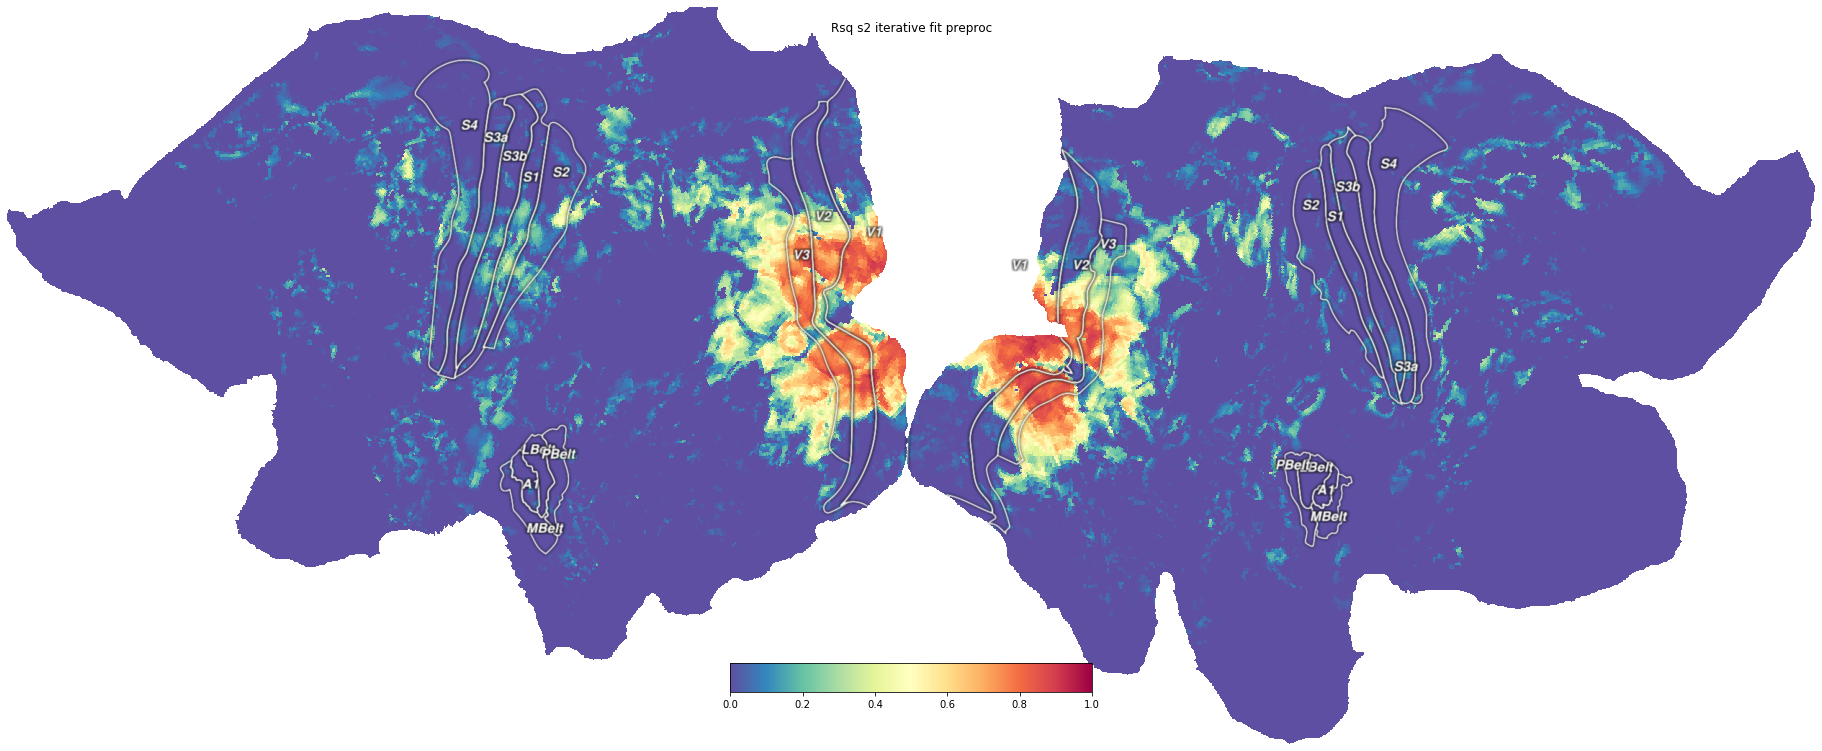

In [27]:
f = cx.quickshow(cx.Vertex(get_cortex(gf_P.iterative_search_params[:,-1]), subject='hcp_999999', cmap='Spectral_r', vmin=0, vmax=1), with_curvature=True);
# zoom_to_roi('hcp_999999', 'V2', hem='')
f.suptitle('Rsq s2 iterative fit preproc')

In [15]:
from prfpy.model import Iso2DGaussianModel, Norm_Iso2DGaussianModel, DoG_Iso2DGaussianModel, CSS_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, Norm_Iso2DGaussianFitter, DoG_Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

In [29]:
gf_P.iterative_search_params = get_cortex(gf_P.iterative_search_params).shape

(118584, 6)

In [30]:
gg_norm = Norm_Iso2DGaussianModel(stimulus=prf_stim,
                                    filter_predictions=False,
                                    filter_type='dc',
                                    )

gf_norm = Norm_Iso2DGaussianFitter(data=np.nan_to_num(s2_f),
                                   model=gg_norm,
                                   n_jobs=30,
                                   previous_gaussian_fitter=gf_P)

gf_norm.grid_fit(surround_amplitude_grid,
                         surround_size_grid,
                         neural_baseline_grid,
                         surround_baseline_grid,
                         verbose=True,
                         n_batches=60,
                         rsq_threshold=0.01,
                         pos_prfs_only=True)

gf_norm.iterative_fit(rsq_threshold=0.01, verbose=True, bounds=norm_bounds)

gf_norm.crossvalidate_fit(s2_f2,
                 single_hrf=False)

np.save("/scratch/2021/nprf_ss/derivatives/Scalars/sub-02/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold1.npy", gf_norm.iterative_search_params)

Each batch contains approx. 2050 voxels.


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   1 tasks      | elapsed: 10.4min
[Parallel(n_jobs=30)]: Done   7 out of  60 | elapsed: 12.2min remaining: 92.4min
[Parallel(n_jobs=30)]: Done  13 out of  60 | elapsed: 14.6min remaining: 52.7min
[Parallel(n_jobs=30)]: Done  19 out of  60 | elapsed: 14.9min remaining: 32.1min
[Parallel(n_jobs=30)]: Done  25 out of  60 | elapsed: 18.3min remaining: 25.6min
[Parallel(n_jobs=30)]: Done  31 out of  60 | elapsed: 21.4min remaining: 20.0min
[Parallel(n_jobs=30)]: Done  37 out of  60 | elapsed: 24.0min remaining: 14.9min
[Parallel(n_jobs=30)]: Done  43 out of  60 | elapsed: 27.4min remaining: 10.8min
[Parallel(n_jobs=30)]: Done  49 out of  60 | elapsed: 27.6min remaining:  6.2min
[Parallel(n_jobs=30)]: Done  55 out of  60 | elapsed: 29.7min remaining:  2.7min
[Parallel(n_jobs=30)]: Done  60 out of  60 | elapsed: 30.3min finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 conc